In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse import diags
import pixiedust
import itertools

Pixiedust database opened successfully


In [2]:
conn = conn = sqlite3.connect(r'D:\\Studies\\AppliedAi\\AmazonFoodReviews\\Cleaned_Text.sqlite')

filtered_data = pd.read_sql_query("""SELECT CleanedText FROM Reviews""", conn)

In [3]:
filtered_data.head()

,CleanedText
0,alway enjoy movi funni entertain didnt hesit p...
1,realli good idea final product outstand use de...
2,receiv shipment could hard wait tri product lo...
3,continu amaz shoddi treatment movi get dvd rel...
4,let know movi one person favorit ghost movi sa...


In [4]:
all_reviews = filtered_data["CleanedText"].tolist()

In [5]:
del filtered_data

In [6]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=5)
tfidf_data = tfidf_vectorizer.fit_transform(all_reviews)

In [7]:
tfidf_vectorizer.idf_.shape

(10155,)

In [8]:
top_tfidf_indices = list(np.argsort(tfidf_vectorizer.idf_)[::-1])[:2000]

In [9]:
len(top_tfidf_indices)

2000

In [10]:
featureNames = tfidf_vectorizer.get_feature_names()
top_features = [featureNames[i] for i in top_tfidf_indices]

In [11]:
len(top_features)

2000

In [12]:
top_features[0:20]

['disppoint',
 'chedder',
 'pepcid',
 'peoni',
 'flex',
 'tibetan',
 'peg',
 'peev',
 'fleur',
 'ped',
 'perfumi',
 'peal',
 'has',
 'chem',
 'patrick',
 'tilapia',
 'tilda',
 'tilia',
 'tht',
 'distrust']

In [18]:
#%%pixie_debugger

def update_matrix(row_col_tuples, top_features, co_occurence_matrix):
    for row_col in row_col_tuples:
        row = row_col[0]; col = row_col[1]
        if (row in top_features) and (col in top_features):
            row = top_features.index(row)
            col = top_features.index(col)
            co_occurence_matrix[row, col] = co_occurence_matrix[row, col] + 1
            co_occurence_matrix[col, row] = co_occurence_matrix[col, row] + 1

def populate_matrix(window_size, all_reviews, top_features, co_occurence_matrix):
    progress = 0
    print(f'Number of reviews = {len(all_reviews)}')
    for review in [r.split() for r in all_reviews]:
        progress = progress + 1
        print(f'review #-{progress}', end='\r')
        start_sub_string  = review[0: window_size]
        row_col_tuples = list(itertools.combinations(start_sub_string, 2))
        update_matrix(row_col_tuples, top_features, co_occurence_matrix)
        
        sentence_length = len(review)
        for i in range(1, sentence_length):
            
            window_end_index = window_size + i
            
            if window_end_index > sentence_length:
                i = sentence_length
                continue
            
            start_sub_string = review[i : window_end_index]
            last_word = start_sub_string[-1]
            start_sub_string = start_sub_string[0:-1]
            row_col_tuples = list(map(lambda x : (last_word, x), start_sub_string))
            update_matrix(row_col_tuples, top_features, co_occurence_matrix)

co_occurence_matrix = csr_matrix((len(top_features),len(top_features)), dtype='uint32')
            
for i in range(0,len(top_features)):
    co_occurence_matrix[i,i] = 1
    
populate_matrix(5, all_reviews, top_features, co_occurence_matrix)

Number of reviews = 60000


### 200 dimensions explain 68% of the data

In [20]:
svd_200 = TruncatedSVD(n_components=200)
data_200 = svd_200.fit_transform(co_occurence_matrix)
svd_200.explained_variance_ratio_.sum()

0.681847360362582

### 400 dimensions explain 81% of the data

In [21]:
svd_400 = TruncatedSVD(n_components=400)
data_400 = svd_400.fit_transform(co_occurence_matrix)
svd_400.explained_variance_ratio_.sum()

0.8108603029718134

### 600 dimensions explain 84% of the data

In [28]:
svd_600 = TruncatedSVD(n_components=600)
data_600 = svd_600.fit_transform(co_occurence_matrix)
svd_600.explained_variance_ratio_.sum()

0.8424408810030994

## Beyond 600 increase in dimensions does no increase the variance explained drastically

In [32]:
std_scalar = StandardScaler()
data_600_std = std_scalar.fit_transform(data_600)

In [35]:
type(data_600_std)

numpy.ndarray

In [36]:
data_600_std.shape

(2000, 600)

In [37]:
import operator
import math
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
def GetDotProduct(v1, v2):
    return sum(map(operator.mul, v1, v2))


def GetCosineSimilarity(v1, v2):
    prod = GetDotProduct(v1, v2)
    len1 = math.sqrt(GetDotProduct(v1, v1))
    len2 = math.sqrt(GetDotProduct(v2, v2))
    return prod / (len1 * len2)

In [39]:
def GetSimilarWords(interested_word, number_of_similar_words):
    index_of_the_word = top_features.index(interested_word)
    cosine_similarities = []
    all_indices_except_interested_word = list(range(0,2000))
    all_indices_except_interested_word.remove(index_of_the_word)
    for i in all_indices_except_interested_word:
        cos_sim = GetCosineSimilarity(data_600_std[index_of_the_word], data_600_std[i])
        cosine_similarities.append(cos_sim)
    
    top_n_similar_word_indices = np.argsort(cosine_similarities)[::-1][:number_of_similar_words]
    print(top_n_similar_word_indices)
    return [top_features[i] for i in top_n_similar_word_indices]

In [41]:
import random

### Using Cosine similarity to calculate the similarity and getting 5 closest words 

In [43]:
def GetWords():
    word_indices = random.sample(range(0,2000), 5)
    random_5_words = [top_features[i] for i in word_indices]
    for random_word in random_5_words:
        print('*'*127)
        print(f'Word of interest - {random_word}')
        similar_words = GetSimilarWords(random_word, 5)
        for (index,similar_word) in enumerate(similar_words):
            print(f'Similar word #{index+1} -> {similar_word}')
        print('*'*127)
        
GetWords()

*******************************************************************************************************************************
Word of interest - oacute
[ 597  528  566 1068  559]
Similar word #1 -> rehab
Similar word #2 -> camellia
Similar word #3 -> arkansa
Similar word #4 -> instantan
Similar word #5 -> stoop
*******************************************************************************************************************************
*******************************************************************************************************************************
Word of interest - thees
[1001 1865  878 1978   78]
Similar word #1 -> whisker
Similar word #2 -> cheeper
Similar word #3 -> luke
Similar word #4 -> aquir
Similar word #5 -> agon
*******************************************************************************************************************************
**************************************************************************************************************************

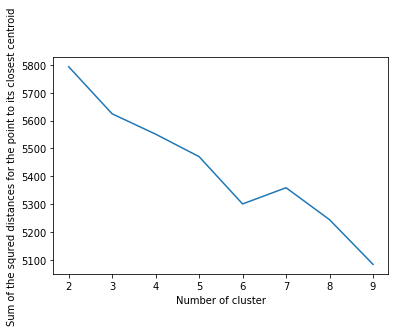

In [45]:
elbow_dict = {}
for k in range(2,10):
    cluster_model = KMeans(k, n_jobs = -1).fit(data_600)
    elbow_dict[k] = cluster_model.inertia_

plt.figure()
plt.plot(list(elbow_dict.keys()), list(elbow_dict.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of the squred distances for the point to its closest centroid")
plt.show()

### Elbow method revealed 6 as the best K

In [ ]:
best_k = 6
best_model = KMeans(best_k, n_jobs = -1).fit(data_600_std)

labels = np.array(best_model.labels_)

In [52]:

for cluster_label in range(0, best_k):
    
    grouped_cluster = np.where(labels == cluster_label)[0]
    
    if(grouped_cluster.size < 5):
        continue

    print("*" * 127)
    print("=" * 30)
    print(f'Cluster Number {cluster_label}')
    print("=" * 30)
    
    cluster_words = [top_features[i] for i in grouped_cluster]
    
    random_indices = random.sample(range(0,grouped_cluster.size), 5) 
    
    for i in random_indices:
        print(cluster_words[i])
        print("-" * 127)
    
    print("*" * 127)

*******************************************************************************************************************************
Cluster Number 0
overblown
-------------------------------------------------------------------------------------------------------------------------------
streak
-------------------------------------------------------------------------------------------------------------------------------
obliter
-------------------------------------------------------------------------------------------------------------------------------
edema
-------------------------------------------------------------------------------------------------------------------------------
2002
-------------------------------------------------------------------------------------------------------------------------------
*******************************************************************************************************************************
***************************************************